# Text Tutorial - Words Embeddings

In [9]:
from warnings import filterwarnings
filterwarnings('ignore')

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
MEMORY_LIMIT_CONFIG = [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
tf.config.experimental.set_virtual_device_configuration(gpus[0], MEMORY_LIMIT_CONFIG)
# print(tf.test.is_gpu_available()) 

True


In [5]:
# setup
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [6]:
embedding_layer = layers.Embedding(input_dim=1000, output_dim=5)

In [7]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.00789005,  0.04951346, -0.00210851, -0.02410178,  0.03705089],
       [ 0.04840625,  0.00351384, -0.02935894, -0.00249761,  0.00116213],
       [ 0.02533914,  0.04913444, -0.01106675, -0.00645171,  0.02057394]],
      dtype=float32)

In [34]:
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', 
                                          split = (tfds.Split.TRAIN, tfds.Split.TEST), 
                                          with_info=True, as_supervised=True)

In [13]:
encoder = info.features['text'].encoder
encoder.subwords[:10]

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br']

In [14]:
# batch size = 10
padded_shapes = ([None],())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)

In [28]:
train_batch, train_labels = next(iter(train_batches))
train_batch

<tf.Tensor: id=197, shape=(10, 814), dtype=int64, numpy=
array([[2130,   12,  538, ...,    0,    0,    0],
       [3566,  132, 3197, ...,    0,    0,    0],
       [8025, 7410, 2977, ...,   21,   39, 7992],
       ...,
       [ 249,    4,  851, ...,    0,    0,    0],
       [ 592, 6066, 7961, ...,    0,    0,    0],
       [7969, 4465, 1069, ...,    0,    0,    0]])>

In [41]:
train_labels

<tf.Tensor: id=198, shape=(10,), dtype=int64, numpy=array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0])>

In [43]:
embedding_dim = 16
model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [46]:
# eager execution for a minibatch 
print(train_labels)
model(train_batch)

tf.Tensor([0 0 1 0 0 1 0 1 1 0], shape=(10,), dtype=int64)


<tf.Tensor: id=433, shape=(10, 1), dtype=float32, numpy=
array([[0.49675158],
       [0.49621132],
       [0.49990547],
       [0.49692455],
       [0.49752563],
       [0.4981906 ],
       [0.50002015],
       [0.5000883 ],
       [0.49698812],
       [0.49860606]], dtype=float32)>

In [47]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.5059 - accuracy: 0.7538 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2821 - accuracy: 0.8940 - val_loss: 0.3191 - val_accuracy: 0.8400
Epoch 3/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2273 - accuracy: 0.9174 - val_loss: 0.2688 - val_accuracy: 0.8850
Epoch 4/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1979 - accuracy: 0.9310 - val_loss: 0.2929 - val_accuracy: 0.8750
Epoch 5/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1744 - accuracy: 0.9389 - val_loss: 0.3973 - val_accuracy: 0.8250
Epoch 6/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1569 - accuracy: 0.9456 - val_loss: 0.3821 - val_accuracy: 0.8700
Epoch 7/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1445 - accuracy: 0.9501 - val_loss: 0.3221 

In [55]:
vars(history).keys()

dict_keys(['validation_data', 'model', '_chief_worker_only', 'params', 'epoch', 'history'])

In [57]:
vars(history)['params']

{'batch_size': None,
 'epochs': 10,
 'steps': 2500,
 'samples': None,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [60]:
vars(history)['history'].keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [66]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

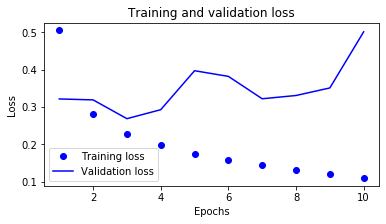

In [67]:
plt.figure(figsize=(6,3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

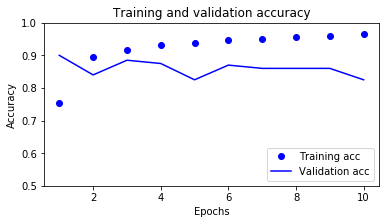

In [70]:
plt.figure(figsize=(6,3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1)) # y-limits of the current axes.
plt.show()

In [71]:
model.layers

In [76]:
e = model.layers[0]
weights = e.get_weights()[0] # return the first element of a list 
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [81]:
len(model.layers[2].get_weights()) # wieght of (linear transformation, bias)
for w in model.layers[2].get_weights():
    print(w.shape) 

(16, 16)
(16,)
